In [123]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl


In [124]:
!ls ../input/nlp-getting-started/

sample_submission.csv  test.csv  train.csv


## BERT Tokenization
Ref: https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py

In [125]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [126]:
import numpy as np
import pandas as pd
import os
import re
import gc
import string
import operator
gc.collect()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as py
py.init_notebook_mode(connected=True)


# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [127]:
train = pd.read_csv('../input/nlp-getting-started//train.csv')
test = pd.read_csv('../input/nlp-getting-started//test.csv')
print('train set shape:', train.shape)
print('train set memory usage is {:.2f} MB'.format(train.memory_usage().sum()/(1024 **2)))
print('test set shape:', test.shape)
print('test set memory usage is {:.2f} MB'.format(test.memory_usage().sum()/(1024 **2)))

train set shape: (7613, 5)
train set memory usage is 0.29 MB
test set shape: (3263, 4)
test set memory usage is 0.10 MB


In [40]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 1. Missing values in train

In [128]:
print('% of Missing values in each column:')
train.isnull().sum()/ len(train)*100

% of Missing values in each column:


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [42]:
# bar plot

missing_vals = train.isnull().sum()
missing_vals.index

trace1 = go.Bar(
                x = missing_vals.index,
                y = missing_vals.values,
                marker = dict(color = missing_vals.values,
                              colorscale='picnic')
            )

layout1 = go.Layout(title = 'missing values count in train')
fig = go.Figure([trace1], layout1)
py.iplot(fig, filename='TrainMissingCount')

# pie chart


trace2 = go.Pie(labels = missing_vals.index,
               values = missing_vals/len(train)*100
               )

layout2 = go.Layout(
                title = 'distribution of missing values',
                font = dict(size=15)
                )
fig = go.Figure([trace2], layout2)
py.iplot(fig, 'TrainMissingDist')

del trace1, trace2

In [43]:
# bar plot
missing_vals = train.isnull().sum()
missing_vals.index

trace1 = go.Bar(
                x = missing_vals.index,
                y = missing_vals.values,
                marker = dict(color = missing_vals.values,
                              colorscale='picnic')
            )

layout1 = go.Layout(title = 'missing values count in train')
fig = go.Figure([trace1], layout1)
py.iplot(fig, filename='TrainMissingCount')

# pie chart


trace2 = go.Pie(labels = missing_vals.index,
                hoverinfo = 'label+percent',
                textposition='outside',
                values = missing_vals/len(train)*100
               )

layout2 = go.Layout(
                title = 'distribution of missing values',
                font = dict(size=15)
                )
fig = go.Figure([trace2], layout2)
py.iplot(fig, 'TrainMissingDist')

del trace1, trace2

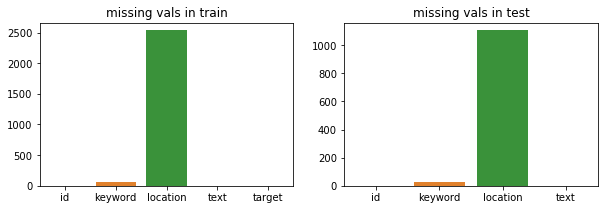

In [129]:
# using seaborn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
sns.barplot(x =missing_vals.index, y = missing_vals.values, ax=ax1)
ax1.set_title('missing vals in train')
sns.barplot(x =test.isnull().sum().index, y = test.isnull().sum().values, ax=ax2)
ax2.set_title('missing vals in test')
plt.show()

### 1.1 Replace missing values in train and test sets

In [130]:
# replace all missing values with : 'no_<column_name>'
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')
        #df[col] = df[col].fillna('no_{col}')

In [131]:
display(train.isnull().sum())
display(test.isnull().sum())

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

id          0
keyword     0
location    0
text        0
dtype: int64

In [46]:
# key word distribution for target
train.groupby('target')['keyword'].count()

target
0    4323
1    3229
Name: keyword, dtype: int64

In [47]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Target distribution for either classes
   * Mean value of 1 means: the keyword occurs only in class '1'
   * Mean value of 0 means: the keyword occurs only in class '0'
   * Anything in between means it occurs in both classes

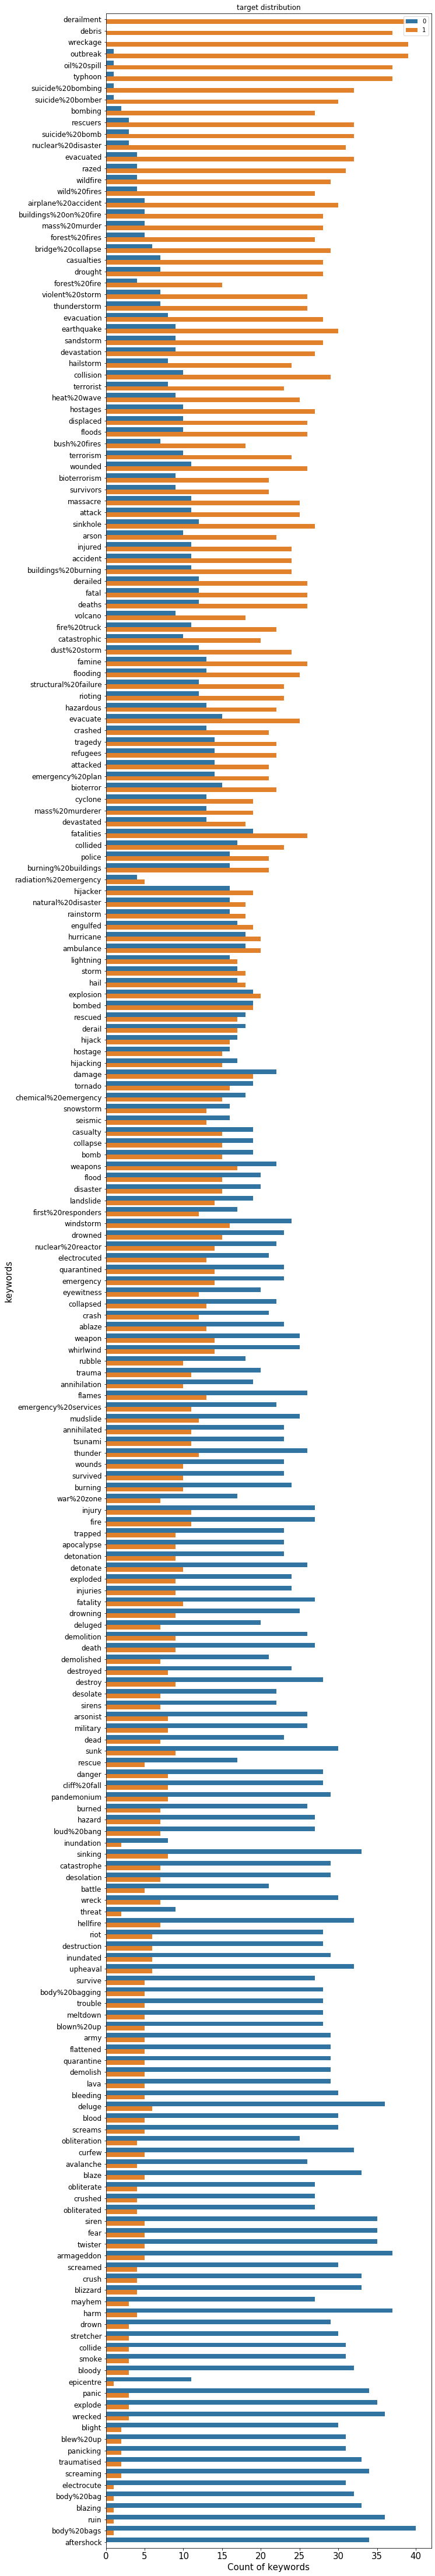

In [48]:
# mean count for each unique word
#train.groupby('keyword')['target'].first()
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')
#train.dropna()

# Count plot
plt.figure(figsize=(10, 80))
sns.countplot(y = train.sort_values('target_mean', ascending=False)['keyword'], 
             hue = train.sort_values('target_mean', ascending=False)['target']
             )
plt.xlabel('Count of keywords', fontsize=15)
plt.ylabel('keywords', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.title('target distribution')
plt.legend(loc='upper right')
plt.show()

### 2.1 Exploring the most frequently use words in either classes separately

In [49]:
train1 = train[train['target']==1]
train0 = train[train['target']==0]

In [50]:
train1.head(5)

,id,keyword,location,text,target,target_mean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN


In [51]:
# Ref: http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/

from collections import defaultdict
from nltk.corpus import stopwords
stop = stopwords.words('english')

def generate_ngrams(text, n_gram=1):
    
    tokens = [token for token in text.lower().split() if token != "" if token not in stop and len(token) > 1]    
    # generate n_grams
    ngrams = zip(*[tokens[i:] for i in range(n_gram)])
    # join all the ngrams
    return [" ".join(ngram) for ngram in ngrams]


def plot_bar(df, color, classify):
    trace = go.Bar(
                    y = df['word'].values[::-1],
                    x = df['frequency'].values[::-1],
                    showlegend=False,
                    name = classify, # argument for passing 'disaster' or 'non disaster'
                    orientation='h',
                    marker = dict(
                                color= color),
    )
    return trace
                 
freq_dict_disaster = defaultdict(int)
for sent in train1['text']:
    for word in generate_ngrams(sent):
        freq_dict_disaster[word]+=1
        
# create a dataframe
# sort the dictionary by the values
# Method: 1 create a dataframe and sort
#pd.DataFrame(freq_dict.items(), columns=['words', 'count']).sort_values('count', ascending=False).reset_index(drop=True)

# Method: 2 sort the dictionary and then create the dataframe
freq_sorted_disaster = pd.DataFrame(sorted(freq_dict_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace1 = plot_bar(freq_sorted_disaster.head(50), 'red', 'disaster')

# layout = go.Layout(title = 'Most frequent words in disaster tweets',
#                   height=800,
#                   width=500)
# fig = go.Figure(trace, layout)
# py.iplot(fig)
# plt.show()


# now for the non-disaster tweets
freq_dict_no_disaster = defaultdict(int)
for sent in train0['text']:
    for word in generate_ngrams(sent):
        freq_dict_no_disaster[word]+=1
        
freq_sorted_no_disaster = pd.DataFrame(sorted(freq_dict_no_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace2 = plot_bar(freq_sorted_no_disaster.head(50), 'blue', 'No_disaster')

# create as subplots

fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5],
                    vertical_spacing=0.5,
                    print_grid=True,
                    subplot_titles=['frequent words in disaster tweets',
                                  'frequent words in non_disaster tweets'])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.update_layout(title = 'Unigrams count(top 50) in tweets',
                  height = 1000,
                  width = 900)
py.iplot(fig)

del freq_dict_disaster
del freq_sorted_no_disaster
gc.collect()

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



16421

### 2.2 Unigrams count plots:
   * The most frequent words are giving some information in distinguishing between different tweets
   * punctuations are common in both types of tweets and they will need to be removed along with any integers
 

### 2.3 Bigrams count plots:

In [52]:
# disaster tweets - bigrams

# generate_ngrams(text, n_gram=1)

freq_dict_disaster = defaultdict(int)
for sent in train1['text']:
    for word in generate_ngrams(sent, 2):
        freq_dict_disaster[word]+=1
        

freq_sorted_disaster = pd.DataFrame(sorted(freq_dict_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace1 = plot_bar(freq_sorted_disaster.head(50), 'red', 'disaster')


# non-disaster tweets - bigrams
freq_dict_no_disaster = defaultdict(int)
for sent in train0['text']:
    for word in generate_ngrams(sent, 2):
        freq_dict_no_disaster[word]+=1
        
freq_sorted_no_disaster = pd.DataFrame(sorted(freq_dict_no_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace2 = plot_bar(freq_sorted_no_disaster.head(50), 'blue', 'No_disaster')

# create as subplots

fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5],
                    vertical_spacing=0.5,
                    print_grid=True,
                    subplot_titles=['frequent bigrams in disaster tweets',
                                  'frequent bigrams in non_disaster tweets'])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.update_layout(title = 'bigrams count(top 50) in tweets',
                  height = 1000,
                  width = 900)
py.iplot(fig)

del freq_dict_disaster
del freq_sorted_no_disaster
gc.collect()

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



37593

### 2.3 Bigrams count plots analysis:
 * the bigrams are already giving more information into identifying different types of tweets
 * clean up of the punctuations should give a clearer text
 * Looks like most of the non-disaster tweets have a hastag, for instance @youtube, which is the most frequent hastags

### 2.4 Trigrams count plots 

In [53]:
# disaster tweets - trigrams
# generate_ngrams(text, n_gram=1)

freq_dict_disaster = defaultdict(int)
for sent in train1['text']:
    for word in generate_ngrams(sent, 3):
        freq_dict_disaster[word]+=1
        

freq_sorted_disaster = pd.DataFrame(sorted(freq_dict_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace1 = plot_bar(freq_sorted_disaster.head(50), 'red', 'disaster')


# non-disaster tweets - trigrams
freq_dict_no_disaster = defaultdict(int)
for sent in train0['text']:
    for word in generate_ngrams(sent, 3):
        freq_dict_no_disaster[word]+=1
        
freq_sorted_no_disaster = pd.DataFrame(sorted(freq_dict_no_disaster.items(), key = lambda x: x[1])[::-1], columns=['word', 'frequency'])
trace2 = plot_bar(freq_sorted_no_disaster.head(50), 'blue', 'No_disaster')

# create as subplots

fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5],
                    vertical_spacing=0.5,
                    print_grid=True,
                    subplot_titles=['frequent trigrams in disaster tweets',
                                  'frequent trigrams in non_disaster tweets'])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.update_layout(title = 'trigrams count(top 50) in tweets',
                  height = 1000,
                  width = 1500)
py.iplot(fig)

del freq_dict_disaster
del freq_sorted_no_disaster
gc.collect()

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



37593

### 2.4 Trigrams count plots analysis:
 * there is more clarity in the information when we look into trigrams
 * in some of the tweets, the number seem to be more relevant, for instance "MH370 airline crash", year, age, count of people, families etc

## 3. Meta features
We will create some meta features and see how they are distributed between either classes as this could give more information to the model in distinguishing between
either classes of tweets:

The meta features that will be explored are:
1. number of words in the text
2. number of unique words in the text
3. number of characters in the text
4. number of stopwords
5. number of punctuations
6. number of hastags ('#')
7. mention_count('@') (this is more frequent in the non-disaster class of tweets)
8. average character count in words

In [54]:
# count for hastags '#'
train['hashtag_count'] = train['text'].apply(lambda x: len([p for p in str(x) if p == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([p for p in str(x) if p == '#']))

# count of mention
train['mention_count'] = train['text'].apply(lambda x: len([p for p in str(x) if p == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([p for p in str(x) if p == '@']))

# word count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique word count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop words count
train['stop_words'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
test['stop_words'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))

# url count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean word length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation count
train['punctuation_count'] = train['text'].apply(lambda x: len([p for p in str(x).split() if p in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([p for p in str(x).split() if p in string.punctuation]))

* Check the distribution of these meta features in either classes. 
* The distribution can help to identify important features to distinguish between the classes

In [55]:
train.head(5)

,id,keyword,location,text,target,target_mean,hashtag_count,mention_count,word_count,unique_word_count,stop_words,url_count,mean_word_length,char_count,punctuation_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,NaN,1,0,13,13,6,0,4.384615,69,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,NaN,0,0,7,7,0,0,4.571429,38,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,NaN,0,0,22,20,11,0,5.090909,133,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,1,0,8,8,1,0,7.125000,65,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,NaN,2,0,16,15,7,0,4.500000,88,0


Text(0.5, 1.0, 'char_count in each class')

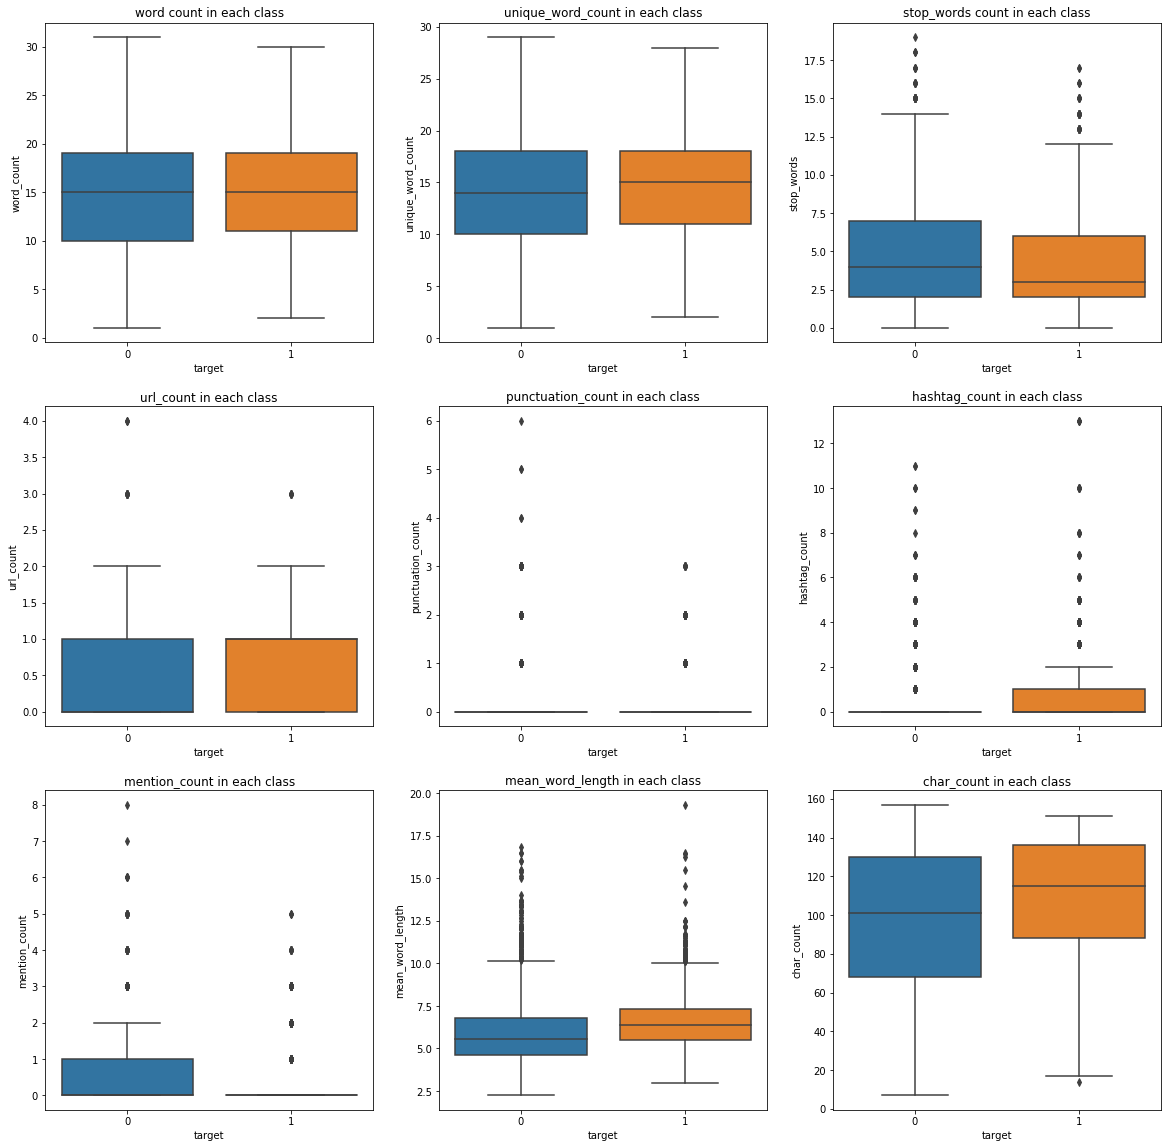

In [56]:
#sns.boxplot(x = train['target'], y= train['word_count'])
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
sns.boxplot(data = train, x='target', y = 'word_count', ax=ax[0][0])
ax[0][0].set_title('word count in each class')
sns.boxplot(data = train, x='target', y = 'unique_word_count', ax=ax[0][1])
ax[0][1].set_title('unique_word_count in each class')
sns.boxplot(data = train, x='target', y = 'stop_words', ax=ax[0][2])
ax[0][2].set_title('stop_words count in each class')
sns.boxplot(data = train, x='target', y = 'url_count', ax=ax[1][0])
ax[1][0].set_title('url_count in each class')
sns.boxplot(data = train, x='target', y = 'punctuation_count', ax=ax[1][1])
ax[1][1].set_title('punctuation_count in each class')
sns.boxplot(data = train, x='target', y = 'hashtag_count', ax=ax[1][2])
ax[1][2].set_title('hashtag_count in each class')
sns.boxplot(data = train, x='target', y = 'mention_count', ax=ax[2][0])
ax[2][0].set_title('mention_count in each class')
sns.boxplot(data = train, x='target', y = 'mean_word_length', ax=ax[2][1])
ax[2][1].set_title('mean_word_length in each class')
sns.boxplot(data = train, x='target', y = 'char_count', ax=ax[2][2])
ax[2][2].set_title('char_count in each class')

From the boxplots, features that have slighltly different distribution for either classes are:
- wordcount
- unique_word_count
- stop_words count
- punctuation_count
- mean_word_length
- char_count
- mention_count

** Exploring in detail on the punctuation count** 

In [57]:
train['punctuation_count'].value_counts()

0    6612
1     836
2     119
3      41
5       2
4       2
6       1
Name: punctuation_count, dtype: int64

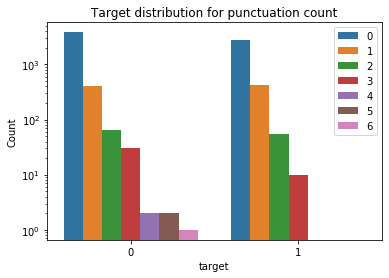

In [58]:
punct = train.groupby(['punctuation_count', 'target']).count()['id']
punct = punct.reset_index()
sns.barplot(data=punct, x = 'target', y = 'id', hue = 'punctuation_count')
plt.legend(loc='upper right')
plt.yscale('log')# converting to log to visualize the lower count
plt.title('Target distribution for punctuation count')
plt.ylabel('Count')
plt.show()

** Exploring in detail on the hashtag_count ** 

In [59]:
train['hashtag_count'].value_counts()

0     5852
1      964
2      405
3      208
4       83
5       41
6       26
10      10
7        8
8        8
13       4
11       2
9        2
Name: hashtag_count, dtype: int64

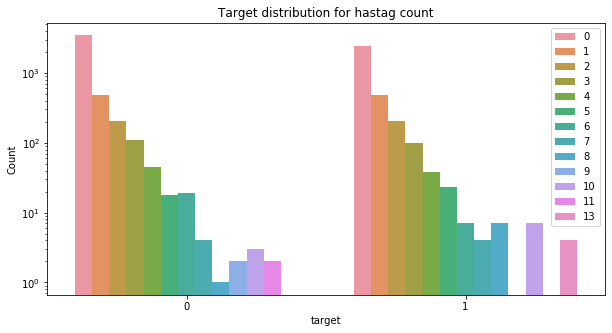

In [60]:
hastag = train.groupby(['hashtag_count', 'target']).count()['id']
hastag =hastag.reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(data=hastag, x = 'target', y = 'id', hue = 'hashtag_count')
plt.legend(loc='upper right')
plt.yscale('log')
plt.title('Target distribution for hastag count')
plt.ylabel('Count')
plt.show()

In [61]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl
/kaggle/input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl


## 4. Pre-trained 'Embeddings'

In [62]:
%%time
glove_embeddings = np.load('/kaggle/input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('/kaggle/input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

CPU times: user 11.3 s, sys: 8.41 s, total: 19.7 s
Wall time: 19.8 s


* Words in the intersection of 'vocab' and 'embeddings' are stored in 'covered' along with their counts
* Words in vocab that don't exist in embeddings are stored in 'oov' along with their counts
* 'n_covered' and 'n_oov' are total number of counts and they are used for calculating coverage percentages

In [63]:
# build the vocabulary from given text of tweets

stop = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
pstem = PorterStemmer()


def clean_tweet(tweet):
    try:
        regex = re.compile('[^a-zA-Z]')
        tweet = regex.sub(" ", tweet)
        #tweet = tweet.lower()
        #tweet_words = [pstem.stem(word) for word in tweet.split() if word not in stop and len(word) > 2]
        tweet_words = [word for word in tweet.split()]
        tweet = ' '.join(tweet_words)
        return tweet
    except:
        return 0

# passing train['text'] as argument

def build_vocab(X):
    try:
        cleaned = X.apply(lambda x: clean_tweet(x))
        tweets = cleaned.apply(lambda sent: sent.split()).values # convert the tweets into a list
        vocab = {}
    
        for tweet in tweets:
            for word in tweet:
                try:
                    vocab[word]+=1
                except KeyError:
                    vocab[word]=1
        return vocab            
    except:
        return 0


# check if the words in the vocab exist in the pre-trained embeddings

def check_embeddings_coverage(X, embedding):
    # get the vocabulary from the tweet texts
    vocab = build_vocab(X)
    
    covered ={}
    oov = {}
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            # store the glove embedding for the word from the vocabulary of tweets
            covered[word] = embedding[word]
            # count
            n_covered += vocab[word]
        except:
            # if the embedding for the word does not exist in the glove embeddings
            oov[word] = vocab[word]
            # count of words not found in glove embeddings
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = n_covered / (n_covered + n_oov)
    
    # sort in descending for the 'out of vocabulary words'
    # sorted(oov.items(), key= lambda x: x[1])[::-1]
    sorted_oov = sorted(oov.items(), key = operator.itemgetter(1))[::-1]
    
    return sorted_oov, vocab_coverage, text_coverage

### 4.1 Using Glove pretrained Embeddings
* Check the coverge of the Glove embeddings on the train and test sets

In [64]:
%%time
train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(train['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['text'], glove_embeddings)

print('Vocabulary Coverage of Glove embedding in the training set is: {:.2f}'.format(train_glove_vocab_coverage))
print('Text Coverage of Glove embedding in the training set is: {:.2f}'.format(train_glove_text_coverage))
print('Vocabulary Coverage of Glove embedding in the test set is:  {:.2f}'.format(test_glove_vocab_coverage))
print('Text Coverage of Glove embedding in the test set is: {:.2f}'.format(test_glove_text_coverage))
print('Number of words in training set for which there is no glove embedding: ', len(train_glove_oov))
print('Number of words in test set for which there is no glove embedding: ', len(test_glove_oov))

Vocabulary Coverage of Glove embedding in the training set is: 0.68
Text Coverage of Glove embedding in the training set is: 0.93
Vocabulary Coverage of Glove embedding in the test set is:  0.74
Text Coverage of Glove embedding in the test set is: 0.93
Number of words in training set for which there is no glove embedding:  8654
Number of words in test set for which there is no glove embedding:  4056
CPU times: user 238 ms, sys: 1.62 ms, total: 240 ms
Wall time: 238 ms


### 4.2 Using fasttext pretrained Embeddings
* Check the coverge of the fast text embeddings on the train and test sets

In [65]:
%%time
train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(train['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test['text'], fasttext_embeddings)

print('Vocabulary Coverage of fasttext_embeddings in the training set is: {:.2f}'.format(train_fasttext_vocab_coverage))
print('Text Coverge of fasttext_embeddings in the training set is: {:.2f}'.format(train_fasttext_text_coverage))
print('Vocabulary Coverage of fasttext_embeddings in the test set is:  {:.2f}'.format(test_fasttext_vocab_coverage))
print('Text Coverage of fasttext_embeddings in the test set is: {:.2f}'.format(test_fasttext_text_coverage))
print('Number of words in training set for which there is no fasttext embedding: ', len(train_fasttext_oov))
print('Number of words in test set for which there is no fasttext embedding: ', len(test_fasttext_oov))

Vocabulary Coverage of fasttext_embeddings in the training set is: 0.68
Text Coverge of fasttext_embeddings in the training set is: 0.93
Vocabulary Coverage of fasttext_embeddings in the test set is:  0.74
Text Coverage of fasttext_embeddings in the test set is: 0.93
Number of words in training set for which there is no fasttext embedding:  8632
Number of words in test set for which there is no fasttext embedding:  4066
CPU times: user 247 ms, sys: 1.18 ms, total: 248 ms
Wall time: 246 ms


**Some findings:**
* *glove embedding* has a better coverage of the vocabulary at 63% instead of 62% for *fast_text*
* Removing *stopword* and keeping only the *stem words* reduces the vocabulary coverage
    * So here I decided to keep them both for higher coverage of embeddings
* Also keeping the case of the text unchanged also gets a higher coverage
    * So I decided to skip the tolower()

In [66]:
train_glove_oov

[('prebreak', 30),
 ('Soudelor', 22),
 ('bestnaijamade', 18),
 ('Funtenna', 17),
 ('ArianaGrande', 11),
 ('Trfc', 9),
 ('abstorm', 8),
 ('IranDeal', 8),
 ('Beyhive', 8),
 ('animalrescue', 7),
 ('Linkury', 7),
 ('fnet', 7),
 ('mhtw', 7),
 ('MTVHottest', 7),
 ('TrapMusic', 7),
 ('djicemoon', 7),
 ('KSAwlYuX', 6),
 ('Bestnaijamade', 6),
 ('okwx', 6),
 ('ProphetMuhammad', 6),
 ('MikeParrActor', 6),
 ('Dorret', 6),
 ('eNCmhz', 6),
 ('eBlOKeVE', 6),
 ('KerrickTrial', 5),
 ('NASAHurricane', 5),
 ('vVPLFQv', 5),
 ('PantherAttack', 5),
 ('YoungHeroesID', 5),
 ('socialnews', 5),
 ('cybKsXHF', 5),
 ('StrategicPatience', 5),
 ('USAgov', 5),
 ('ViralSpell', 5),
 ('IDFire', 4),
 ('Rexyy', 4),
 ('DETECTADO', 4),
 ('WiseNews', 4),
 ('lulgzimbestpicts', 4),
 ('RAmag', 4),
 ('DiamondKesawn', 4),
 ('RaynbowAffair', 4),
 ('XDYK', 4),
 ('vIwXY', 4),
 ('aWO', 4),
 ('LvlH', 4),
 ('OTRAMETLIFE', 4),
 ('rqWuoy', 4),
 ('SummerFate', 4),
 ('unsuckdcmetro', 4),
 ('tubestrike', 4),
 ('AbbsWinston', 4),
 ('wD', 4),

### 4.3 Delete the embeddings

In [67]:
del glove_embeddings, fasttext_embeddings, train_glove_oov, test_glove_oov, train_fasttext_oov, test_fasttext_oov
gc.collect()

38648

## 5. Check for misclassifications
* Check if the same tweet has different target ids - meaning classified as both disaster and non-disaster tweets

### 5.1 Method:1 Using *groupby* with mean of target
- If mean of target is between 0 and 1, it means there are multiple labels
- if either 0 or 1, then then there is only 1 label

In [68]:
train['target_mean'] = train.groupby('text')['target'].transform('mean')
a = train.query('0.0 < target_mean < 1.0')[['text', 'target','target_mean']].sort_values('text')
display(a)
print('tweets with multiple labels associated are: \n', np.sort(list(set(a['text'].values.tolist()))))

,text,target,target_mean
4290,#Allah describes piling up #wealth thinking it...,0,0.333333
4299,#Allah describes piling up #wealth thinking it...,0,0.333333
4312,#Allah describes piling up #wealth thinking it...,1,0.333333
4244,#foodscare #offers2go #NestleIndia slips into ...,0,0.666667
4221,#foodscare #offers2go #NestleIndia slips into ...,1,0.666667
4239,#foodscare #offers2go #NestleIndia slips into ...,1,0.666667
2832,.POTUS #StrategicPatience is a strategy for #G...,0,0.750000
2831,.POTUS #StrategicPatience is a strategy for #G...,1,0.750000
2830,.POTUS #StrategicPatience is a strategy for #G...,1,0.750000
2833,.POTUS #StrategicPatience is a strategy for #G...,1,0.750000


tweets with multiple labels associated are: 
 ['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect'
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption'
 '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4'
 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring'
 'Caution: breathing may be hazardous to your health.'
 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam'
 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife'
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!'
 'I Pledge Allegiance To The P.O.P.E. And The Bu

### 5.2 Method 2: Using *groupby* with nunique

In [132]:
b = train.groupby('text').nunique()['target'].sort_values(ascending=False)
misclassified_tweets = np.sort(b[b>1].index.tolist())
misclassified_tweets

array(['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
       '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
       '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4',
       'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring',
       'Caution: breathing may be hazardous to your health.',
       'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
       'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
       'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
       'I Pledge Allegiance To The P.O

### 5.3 Check for tweets that have repeated the most number of times and most likley have been mislabeled

text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif                            

7613

tweet frequency and number of tweets

1     7434
2       50
3       10
4        4
6        3
10       1
5        1
Name: target, dtype: int64


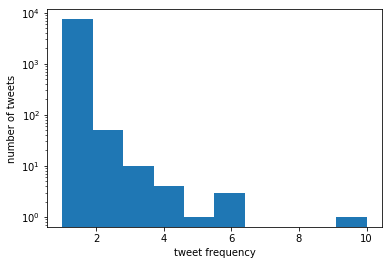

In [70]:
c = train.groupby('text')['target'].count().sort_values(ascending=False)
display(c)
display(len(train))
print('tweet frequency and number of tweets\n')
print(c.value_counts())
#c.plot(kind='hist', range=(2,5))
c.plot(kind='hist')
plt.xlabel('tweet frequency')
plt.ylabel('number of tweets')
plt.yscale('log')
plt.show()

## 6. Assign correct labels for the misclassified tweets

In [71]:
misclassified_tweets

array(['#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
       '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
       '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4',
       'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring',
       'Caution: breathing may be hazardous to your health.',
       'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
       'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
       'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
       'I Pledge Allegiance To The P.O

In [133]:
train['target_relabeled'] = train['target'].copy()
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect'
train.loc[train['text'] == misclassified_tweets[0], 'target_relabeled'] =0
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption
train.loc[train['text'] == misclassified_tweets[1], 'target_relabeled'] =0
# '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4',
train.loc[train['text'] == misclassified_tweets[2], 'target_relabeled'] =1
# CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring',
train.loc[train['text'] == misclassified_tweets[3], 'target_relabeled'] =1
# 'Caution: breathing may be hazardous to your health.',
train.loc[train['text'] == misclassified_tweets[4], 'target_relabeled'] =1
#'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam',
train.loc[train['text'] == misclassified_tweets[5], 'target_relabeled'] =0
#'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you! #Afterlife',
train.loc[train['text'] == misclassified_tweets[6], 'target_relabeled'] =0
#'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
train.loc[train['text'] == misclassified_tweets[7], 'target_relabeled'] =0
#'I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????',
train.loc[train['text'] == misclassified_tweets[8], 'target_relabeled'] =0
#'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
train.loc[train['text'] == misclassified_tweets[9], 'target_relabeled'] =0
#"Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...",
train.loc[train['text'] == misclassified_tweets[10], 'target_relabeled'] =0
#'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG',
train.loc[train['text'] == misclassified_tweets[11], 'target_relabeled'] =0
#"The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
train.loc[train['text'] == misclassified_tweets[12], 'target_relabeled'] =0
'To fight bioterrorism sir.',
train.loc[train['text'] == misclassified_tweets[13], 'target_relabeled'] =0
#'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
train.loc[train['text'] == misclassified_tweets[14], 'target_relabeled'] =1
#'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
train.loc[train['text'] == misclassified_tweets[15], 'target_relabeled'] =0
#'that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time',
train.loc[train['text'] == misclassified_tweets[16], 'target_relabeled'] =0
#'wowo--=== 12000 Nigerian refugees repatriated from Cameroon'
train.loc[train['text'] == misclassified_tweets[17], 'target_relabeled'] =0

In [134]:
gc.collect()

5275

## 7. Cross-validation
* tweets from every *keyword* group exist in both train and test sets and they are from the same sample
* 'StratifiedKFold' will be used to replicate the same technique and 'keyword' will be passed as 'y'
    * This would mean *stratification* would be done based on the *keyword* feature
* By doing so, each fold will have tweets from every *keyword* group in training and validation sets

### 7.1 Use the clean_text function before cross validation

In [135]:
# use the clean_tweet function before cross validation
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
pstem = PorterStemmer()

def clean_tweet(tweet):
    try:
        regex = re.compile('[^a-zA-Z]')
        tweet = regex.sub(" ", tweet)
        tweet = tweet.lower()
        tweet_words = [pstem.stem(word) for word in tweet.split() if word not in stop and len(word) > 2]
        tweet = ' '.join(tweet_words)
        return tweet
    except:
        return 0

In [136]:
%%time
train['text_cleaned'] = train['text'].apply(lambda sent: clean_tweet(sent))
test['text_cleaned'] = test['text'].apply(lambda sent: clean_tweet(sent))

CPU times: user 3.15 s, sys: 512 µs, total: 3.15 s
Wall time: 3.15 s


In [76]:
#?train.sample

In [137]:
display(train[['text', 'text_cleaned']].sample(frac=0.001, random_state=123))
display(test[['text', 'text_cleaned']].sample(frac=0.001, random_state=123))

,text,text_cleaned
1971,1970 Mercury Cyclone GT Hood Moulding Very NIC...,mercuri cyclon hood mould nice core cobra jet ...
2502,The Desolate Hope: Part 2: MIRAD: http://t.co/...,desol hope part mirad http lgtotvsf via youtub
5371,we was all just laughing and talking junk now ...,laugh talk junk everyon panic mode
6258,FINALLY a storm,final storm
549,Dragon Ball Z: Battle Of Gods (2014) - Rotten ...,dragon ball battl god rotten tomato http jddnh...
2367,HereÛªs what caused a Metro train to derail i...,caus metro train derail downtown http imtygd
221,BOOM! Your country was just entirely annihilat...,boom countri entir annihil britain http irfcn szv
6072,Water main break disrupts trolley service http...,water main break disrupt trolley servic http k...


,text,text_cleaned
1497,This whole podcast explosion thing has been we...,whole podcast explos thing weird repli youtub ...
303,@BryanVsBracey @uSTADIUM why do you need blazi...,bryanvsbracey ustadium need blaze speed think ...
1949,New post: Texans report: QB battle unaffected ...,new post texan report battl unaffect foster am...


In [139]:
K=2
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

skf = StratifiedKFold(n_splits = K, random_state=1, shuffle=True)

DISASTER = train['target'] == 1
print('Size of the whole training set is: {}'.format(train.shape))
print('Number of unique keywords in the training set is:  {}'.format(train['keyword'].nunique()))
print('Disaster tweets count: {} / Non-Disaster tweets count:{} in entire training set'.format(train[DISASTER]['target_relabeled'].count(), train[~DISASTER]['target_relabeled'].count()))

# creating the folds
for fold, (train_index, valid_index) in enumerate(skf.split(train['text_cleaned'], train['target'])):
    print('Fold: {}, Training set shape ={}, Validation set shape ={}'\
          .format(fold, train.loc[train_index, 'text_cleaned'].shape, train.loc[valid_index, 'text_cleaned'].shape))
    print('Fold: {}, Training set Unique keyword count= {}, Validation set Unique keyword count ={}'\
          .format(fold, train.loc[train_index, 'keyword'].nunique(), train.loc[valid_index, 'keyword'].nunique()))    

Size of the whole training set is: (7613, 7)
Number of unique keywords in the training set is:  222
Disaster tweets count: 3271 / Non-Disaster tweets count:4342 in entire training set
Fold: 0, Training set shape =(3806,), Validation set shape =(3807,)
Fold: 0, Training set Unique keyword count= 222, Validation set Unique keyword count =222
Fold: 1, Training set shape =(3807,), Validation set shape =(3806,)
Fold: 1, Training set Unique keyword count= 222, Validation set Unique keyword count =222


In [121]:
train.isnull().sum()

id                   0
keyword              0
location             0
text                 0
target               0
target_mean          0
hashtag_count        0
mention_count        0
word_count           0
unique_word_count    0
stop_words           0
url_count            0
mean_word_length     0
char_count           0
punctuation_count    0
target_relabeled     0
text_cleaned         0
dtype: int64

In [99]:
train[['text', 'text_cleaned', 'target_relabeled']]

,text,text_cleaned,target_relabeled
31,@bbcmtd Wholesale Markets ablaze http://t.co/l...,bbcmtd wholesal market ablaz http lhyxeohi,1
32,We always try to bring the heavy. #metal #RT h...,alway tri bring heavi metal http yao xngw,0
33,#AFRICANBAZE: Breaking news:Nigeria flag set a...,africanbaz break news nigeria flag set ablaz a...,1
34,Crying out for more! Set me ablaze,cri set ablaz,0
35,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,plu side look sky last night ablaz http qqsmshaj,0
...,...,...,...
7578,@jt_ruff23 @cameronhacker and I wrecked you both,ruff cameronhack wreck,0
7579,Three days off from work and they've pretty mu...,three day work pretti much wreck hahaha shouto...,0
7580,#FX #forex #trading Cramer: Iger's 3 words tha...,forex trade cramer iger word wreck disney stoc...,0
7581,@engineshed Great atmosphere at the British Li...,enginesh great atmospher british lion gig toni...,0


## 8. Model

### 8.1 Metric selection
* Use *precision*, *recall*, *accuracy*, *f1 score* as the metrics
* The leaderboard is based on *Mean F-Score*

In [140]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores=[]
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores=[]
        
        
    def end_of_epoch(self, epoch, logs={}):
        train_predictions = np.round(elf.model.predict(self.X_train, verbose=0))
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(elf.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)
        self.val_recall_scores.append(val_recall)
        self.val_f1_scores.append(val_f1)
        
        print('Epoch: {} - Training Precision: {:.2f} - Training Recall: {:.2f} - Training F1: {:.2f}'\
              .format(epoch+1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.2f} - Validation Recall: {:.2f} - Validation F1: {:.2f}'\
              .format(epoch+1, val_precision, val_recall, val_f1))

### 8.2  Using BERT layer
* This model uses the implementation of BERT from the TensorFlow Models repository on GitHub at tensorflow/models/official/nlp/bert
* It uses L=12 hidden layers (Transformer blocks), a hidden size of H=768, and A=12 attention heads
* This model has been pre-trained for English on the Wikipedia and BooksCorpus
* Inputs have been "uncased", meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped

In [141]:
import tensorflow as tf
import tensorflow_hub as hub # TensorFlow Hub is a library for reusable machine learning modules. Ref: https://www.tensorflow.org/hub

In [142]:
%%time
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)
# trainable=True, means this layer will be used for training

CPU times: user 6.56 s, sys: 1.19 s, total: 7.75 s
Wall time: 7.56 s


* The *tokenization* of the input text is done by the *FullTokenizer* class from *tokenization.py*
* Create a new class 'DisasterDetector' that will call the cross_validation and other metrics

In [143]:
class DisasterDetector:
    
    def __init__(self, bert_layer, max_seq_length=128, lr=0.0001, epochs=15, batch_size=32):
        
        # BERT and tokenization parameters
        self.bert_layer = bert_layer
        self.max_seq_length = max_seq_length
    
        
        from tokenization import FullTokenizer
        
        # create the vocab file
        vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
        #self.tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
        self.tokenizer = FullTokenizer(vocab_file, do_lower_case)
    
        # learning control parameters
        self.lr = lr
        self.epochs =epochs
        self.batch_size = batch_size
        
        # models
        self.models =[]
        self.scores ={}
    
    def encode(self, texts):
        
        all_tokens = []
        all_masks = []
        all_segments = []
    
        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)
            
            # convert tokens to ids using convert_tokens_to_ids method from tokenization.py
            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len # repeates [0], pad_len times
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length
    
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
    
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length), dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length), dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length), dtype=tf.int32, name='segment_ids')
        
        pooled_output, sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])
        clf_output = sequence_output[:,0,:]
        out = Dense(1, activation= 'sigmoid')(clf_output)
        
        model = Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = out)
        optimizer = SGD(learning_rate = self.lr, momentum=0.8)
        
        model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])
        return model
    
    
    def train(self, X):
        for fold, (train_index, valid_index) in enumerate(skf.split(X['text_cleaned'], X['keyword'])):
            print('Fold: {} \n',format(fold))
            
            # train
            X_train_encoded = self.encode(X.loc[train_index, 'text_cleaned'].str.lower())
            y_train = X.loc[train_index, 'target_relabeled']
            
            # validation
            X_val_encoded = self.encode(X.loc[valid_index, 'text_cleaned'].str.lower())
            y_val = X.loc[valid_index, 'target_relabeled']
            
            
            # Callbacks
            metrics = ClassificationReport(train_data = (X_train_encoded, y_train), validation_data = (X_val_encoded, y_val))
            
            # model
            model = self.build_model()
            model.fit(X_train_encoded, y_train,\
                     validation_data = (X_val_encoded, y_val),\
                     callbacks = [metrics],\
                     epochs = self.epochs,\
                     batch_size= self.batch_size)
            
            self.models.append(model)
            
            self.scores[fold] = {
                    'train': {
                        'precision': metrics.train_precision_scores,
                        'recall': metrics.train_recall_scores,
                        'f1': metrcis.train_f1_scores
                            },
                    'validation':{
                        'precision': metrics.val_precision_scores,
                        'recall': metrics.val_recall_scores,
                        'f1': metrics.val_f1_scores
                                }
                        }
            
            
        def predict(self, X):
            
            X_test_encoded = self.encode(X['text_cleaned'].str.lower())
            y_pred = np.zeros(X_test_encoded[0].shape[0], 1)
            
            for model in self.models:
                # taking the average
                y_pred += model.predict(X_test_encoded) / len(self.models)
            
            return y_pred

In [144]:
gc.collect()

76

In [146]:
%%time
#clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=10, batch_size=32)
clf = DisasterDetector(bert_layer, max_seq_length=128, lr=0.0001, epochs=5, batch_size=32)
clf.train(train)

Fold: {} 
 0
Train on 3806 samples, validate on 3807 samples
Epoch 1/5
 384/3806 [==>...........................] - ETA: 34:21 - loss: 0.6668 - accuracy: 0.5824

KeyboardInterrupt: 

## 9. Prediction

In [ ]:
y_pred = clf.predict(test)